In [1]:
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession
from pyspark.sql.functions import*

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DoubleType

import pandas as pd
spark = SparkSession.builder.appName("customer").getOrCreate()

In [3]:
df_cc= spark.read.load('json\cdw_sapp_credit.json', format='json',header=True,inferSchema=True)

In [4]:
df_cc.printSchema()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- DAY: long (nullable = true)
 |-- MONTH: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: long (nullable = true)



lets change the data type of each date column ot string so as to convert into concat

In [5]:
#pyspark.sql.functions.lpad(col, len, pad)[source]


df_cc = df_cc.withColumn('MONTH', lpad(df_cc['MONTH'], 2, '0'))


In [6]:
df_cc = df_cc.withColumn('DAY', lpad(df_cc['DAY'], 2, '0'))


In [7]:
df_cc=df_cc.withColumn('DAY',df_cc['DAY'].cast('String'))
df_cc=df_cc.withColumn('MONTH',df_cc['MONTH'].cast('String'))
df_cc=df_cc.withColumn('YEAR',df_cc['YEAR'].cast('String'))

In [8]:
#concat to yyyyddmm format
df_cc=df_cc.withColumn('TIMEID',concat(df_cc['YEAR'],df_cc['MONTH'],df_cc['DAY']))

In [9]:
df_cc=df_cc.drop('DAY','MONTH','YEAR')

In [10]:
df_cc.printSchema()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- TIMEID: string (nullable = true)



In [11]:
df_cc=df_cc.withColumnRenamed('CREDIT_CARD_NO','CUST_CC_NO')

loading in db

In [12]:
df_cc.write.format("jdbc") \
  .mode("overwrite") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_CREDIT_CARD") \
  .option("user", "root") \
  .option("password", "password") \
  .save()


In [13]:
df_new1 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_CREDIT_CARD") \
  .option("user", "root") \
  .option("password", "password") \
  .load()

df_new1.show()


+-----------+----------------+---------+--------------+----------------+-----------------+--------+
|BRANCH_CODE|      CUST_CC_NO| CUST_SSN|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|  TIMEID|
+-----------+----------------+---------+--------------+----------------+-----------------+--------+
|        180|4210653342242023|123451310|         45069|           Bills|            77.79|20180315|
|        107|4210653342242023|123451310|         45070|      Healthcare|            20.47|20180419|
|         58|4210653342242023|123451310|         45071|      Healthcare|             1.61|20180628|
|         85|4210653342242023|123451310|         45072|             Gas|            73.86|20180306|
|        123|4210653342242023|123451310|         45073|      Healthcare|             28.4|20180816|
|        124|4210653342242023|123451310|         45074|       Education|            55.39|20181201|
|         30|4210653342242023|123451310|         45075|             Gas|            22.99|20180618|


In [14]:
type(df_new1)

pyspark.sql.dataframe.DataFrame

In [15]:
df=df_new1.toPandas()

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\ngupt\AppData\Local\Temp\ipykernel_15672\3647279718.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df[['TRANSACTION_TYPE', 'TRANSACTION_VALUE']].groupby(df['TRANSACTION_TYPE']).sum()


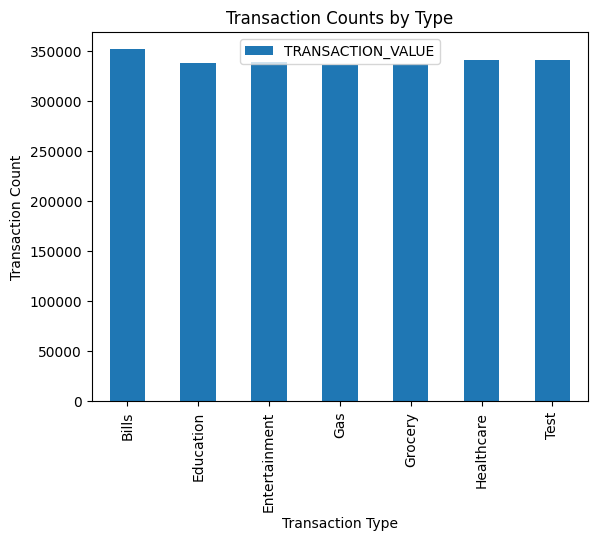

In [18]:
#3 .. Find and plot which transaction type has a high rate of transactions.

def transact_type_cnt():

    df1 = df[['TRANSACTION_TYPE','TRANSACTION_VALUE']].groupby(df['TRANSACTION_TYPE']).sum()
    df1.reset_index(inplace=True)

    df1.plot(kind='bar', x='TRANSACTION_TYPE', y='TRANSACTION_VALUE')
    plt.title('Transaction Counts by Type')
    plt.xlabel('Transaction Type')
    plt.ylabel('Transaction Count')
    plt.show()



C:\Users\ngupt\AppData\Local\Temp\ipykernel_20656\3884989755.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cc1 = df[['CUST_SSN', 'TRANSACTION_VALUE']].groupby(df['CUST_SSN']).sum()


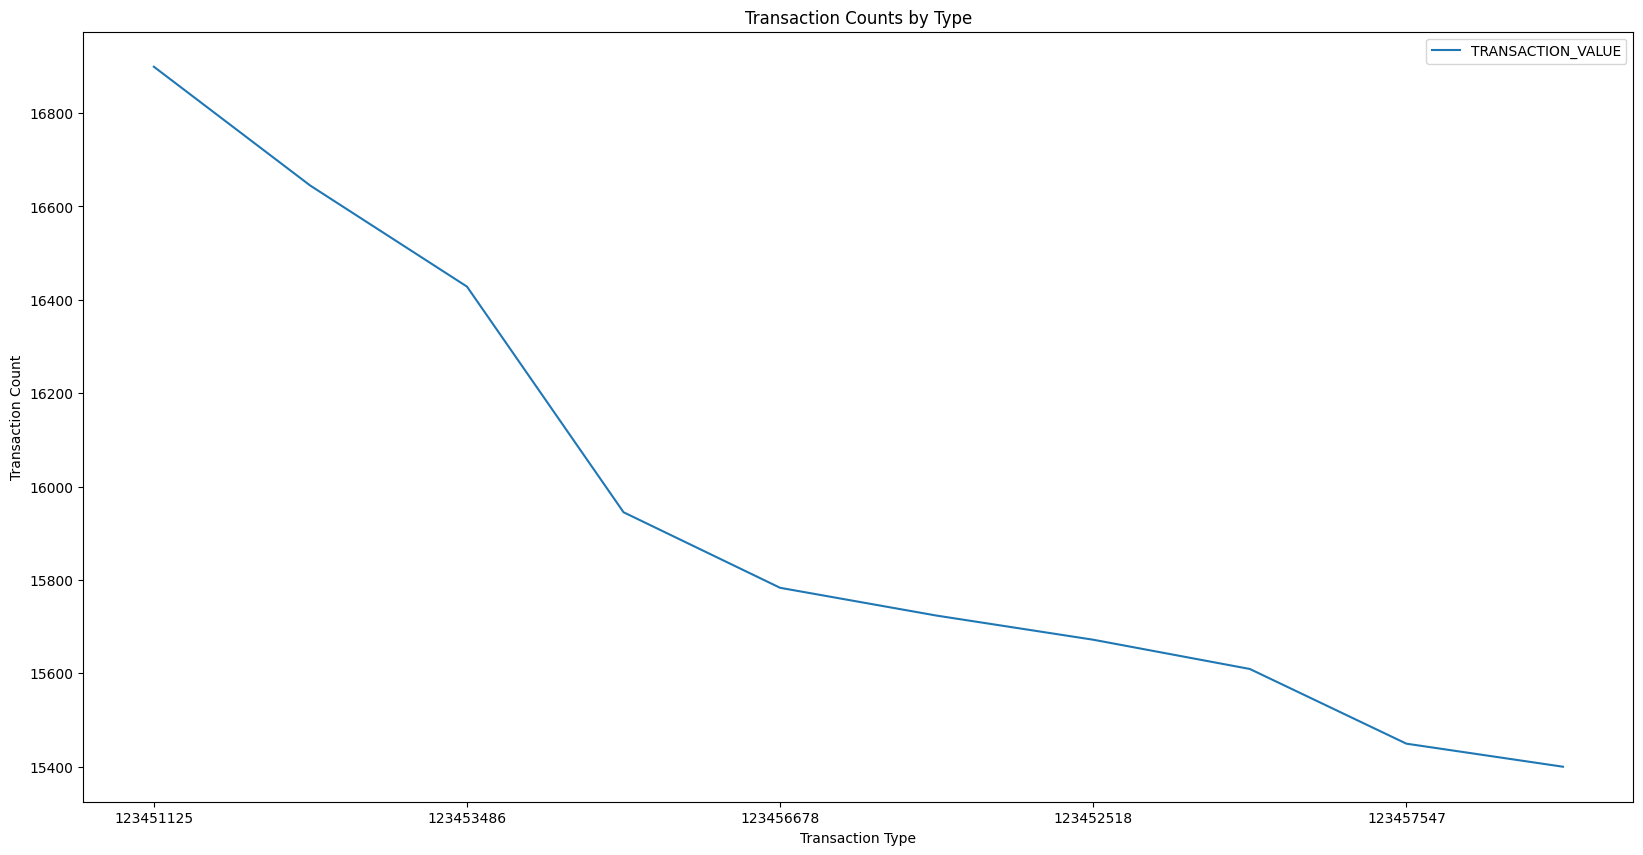

In [ ]:
#top 10 customers with higher transactions
import pandas as pd
import matplotlib.pyplot as plt

#df_cc = pd.read_json(r'C:\Users\ngupt\OneDrive\Desktop\perschoolas\CapstoneETL\json\cdw_sapp_credit.json',  lines = True)
# print(df_cc)
def cust_transact():

    df['CUST_SSN'] = df['CUST_SSN'].astype('string')


    df_cc1 = df[['CUST_SSN', 'TRANSACTION_VALUE']].groupby(df['CUST_SSN']).sum()
    df_cc1.reset_index(inplace=True)
    df_cc1=df_cc1.sort_values(by=['TRANSACTION_VALUE'],ascending=False)
    df_cctop=df_cc1.head(10)

    df_cctop.plot(kind='line', x='CUST_SSN', y='TRANSACTION_VALUE', figsize=(20,10))
    plt.title('Top 10 customers')
    plt.xlabel('Customers-ID')
    plt.ylabel('Transaction value')
    plt.show()
